# 1.Sentiment Analysis

### This work tries to classifying sentiment from financial news using Combination Doc2vec and LSTM

### What is Sentimen Analysis ?

Sentiment analysis refers to the use of natural language processing, text analysis, computational linguistics, and biometrics to systematically identify, extract, quantify, and study affective states and subjective information. Sentiment Analysis [2]: the process of understanding if a given text is talking positively or negatively about a given subject, aiming for brand monitoring.




# 2. LSTM Model

Long Short Term Memory (LSTM) is a special kind of Recurrent Neural Network (RNN), capable of learning long-term dependencies. These long-term dependencies have a great influence on the meaning and overall polarity of a document. Long short-term memory networks (LSTM) address this long-term dependency problem by introducing a memory into the network. It was first introduced by **Hochreiter & Schmidhuber**.

![Long_Short-Term.png](Long_Short-Term.png)


The LSTM architecture has a range of repeated modules for each time step as in a standard RNN. At each time step, the output of the module is controlled by a set of gates, as a function of the old hidden state ℎ𝑡−1 and the input at the current time step 𝑥𝑡 : the forget gate 𝑓𝑡, the input gate 𝑖𝑡 , and the output gate 𝑂𝑡 . These gates collectively decide how to update the current memory cell 𝐶𝑡 and the current hidden state ℎ𝑡 . The LSTM transition functions are defined as follows:

𝑖𝑡=(𝑊𝑖[ℎ𝑡−1,𝑥𝑡]+𝑏𝑖) 

𝐶´𝑡=𝑡𝑎𝑛ℎ(𝑊𝑐[ℎ𝑡−1,𝑥𝑡]+𝑏𝐶) 

𝑓𝑡=(𝑊𝑓[ℎ𝑡−1,𝑥𝑡]+𝑏𝑓) 

𝑂𝑡=(𝑊𝑜[ℎ𝑡−1,𝑥𝑡]+𝑏𝑜) 

𝐶𝑡= 𝑓𝑡∗𝐶𝑡−1+𝑖𝑡∗𝐶´𝑡

Here 𝜎 is logistic sigmoid function that has an output in 𝑛 [0,1] ,tanh denotes the hyperbolic tangent function that has an output ℎ 𝑖𝑛 [−1,1], and ∗ denotes the pointwise multiplication.


As I mentioned before to deal with Deep learning we have to map sentence to vector of number. In this work inspired by [3] Doc2vec as the embedding used for extracting information context. The Doc2vec is an unsupervised algorithm that learns fixed-length feature representations from variable-length pieces of texts such as sentences, paragraphs, and documents.


# 3.Implement Code

Dataset: https://huggingface.co/datasets/financial_phrasebank

In [3]:
!pip install tensorflow

In [4]:
!pip install wordcloud

In [5]:
import nltk
nltk.download('punkt')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import tensorflow as tf

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument



[nltk_data] Downloading package punkt to /Users/dningg/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Read Dataset

In [6]:
df = pd.read_csv('financial_phrasebank.csv',delimiter=',',encoding='latin-1')
df.head()

,neutral,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing ."
0,neutral,Technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...


In [7]:
df = df.rename(columns={'neutral':'sentiment','According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .':'Message'})

In [8]:
df

,sentiment,Message
0,neutral,Technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...
...,...,...
4840,negative,LONDON MarketWatch -- Share prices ended lower...
4841,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4842,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4843,negative,Net sales of the Paper segment decreased to EU...


In [9]:
df.index = range(4845)
df['Message'].apply(lambda x: len(x.split(' '))).sum()

111964

VISUALIZING THE DATA

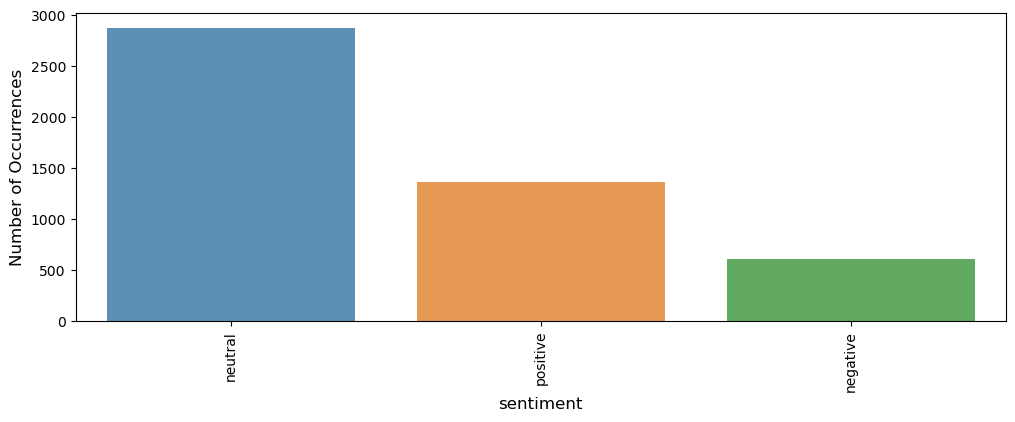

In [10]:
cnt_pro = df['sentiment'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(x=cnt_pro.index, y=cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('sentiment', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [11]:
#Convert sting to numeric
sentiment  = {'positive': 0,'neutral': 1,'negative':2} 

df.sentiment = [sentiment[item] for item in df.sentiment] 
print(df)

      sentiment                                            Message
0             1  Technopolis plans to develop in stages an area...
1             2  The international electronic industry company ...
2             0  With the new production plant the company woul...
3             0  According to the company 's updated strategy f...
4             0  FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...
...         ...                                                ...
4840          2  LONDON MarketWatch -- Share prices ended lower...
4841          1  Rinkuskiai 's beer sales fell by 6.5 per cent ...
4842          2  Operating profit fell to EUR 35.4 mn from EUR ...
4843          2  Net sales of the Paper segment decreased to EU...
4844          2  Sales in Finland decreased by 10.5 % in Januar...

[4845 rows x 2 columns]


In [12]:
def print_message(index):
    example = df[df.index == index][['Message', 'sentiment']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Message:', example[1])
print_message(3)

According to the company 's updated strategy for the years 2009-2012 , Basware targets a long-term net sales growth in the range of 20 % -40 % with an operating profit margin of 10 % -20 % of net sales .
Message: 0


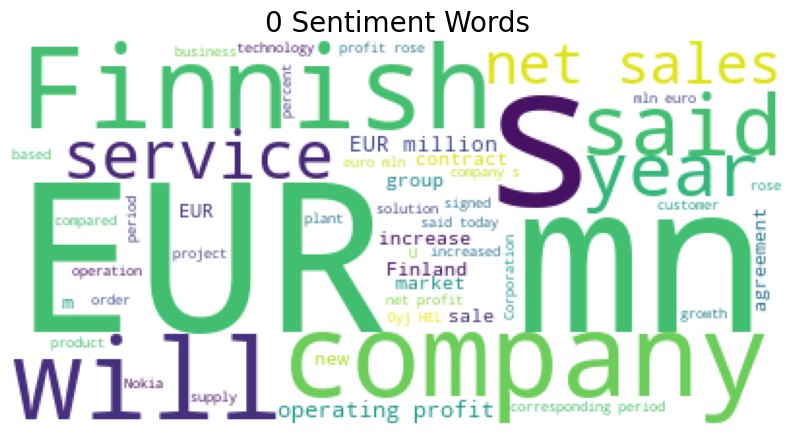

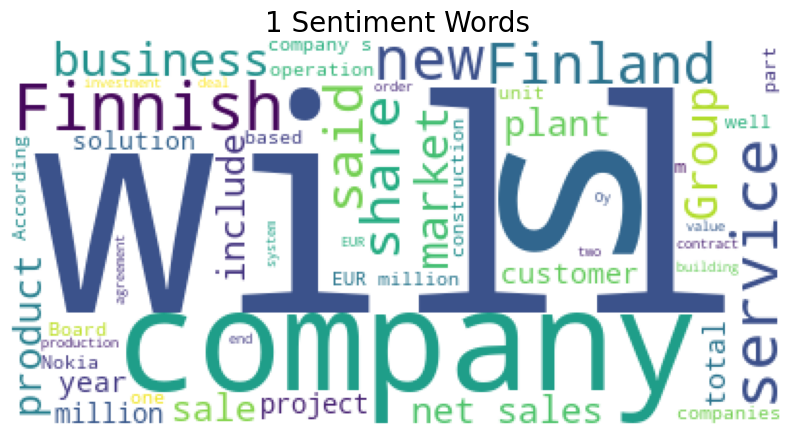

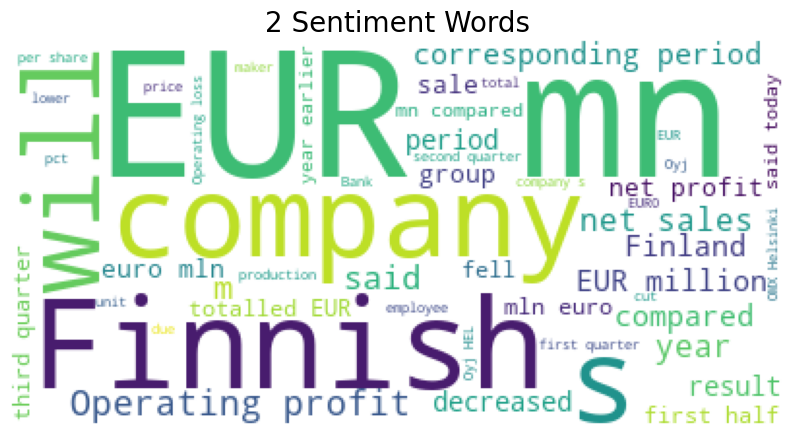

In [13]:
from wordcloud import WordCloud, STOPWORDS

def wordcount_gen(df, sentiment):
    # Combine all tweets
    combined_tweets = " ".join([tweet for tweet in df[df.sentiment==sentiment]['Message']])
                          
    # Initialize wordcloud object
    wc = WordCloud(background_color='white', 
                   max_words=50, 
                   stopwords = STOPWORDS)

    # Generate and plot wordcloud
    plt.figure(figsize=(10,10))
    plt.imshow(wc.generate(combined_tweets))
    plt.title('{} Sentiment Words'.format(sentiment), fontsize=20)
    plt.axis('off')
    plt.show()
    
# Positive tweet words
wordcount_gen(df, 0)
     
# Neutral tweet words
wordcount_gen(df, 1)
     
# Negative tweet words
wordcount_gen(df, 2)

Text Preprocessing Below we define a function to convert text to lower-case and strip punctuation/symbols from words and so on.

In [14]:
from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text
df['Message'] = df['Message'].apply(cleanText)

/var/folders/hh/skldlnlx0579tnk__8txs8th0000gn/T/ipykernel_11902/2959445239.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "lxml").text


In [15]:
train, test = train_test_split(df, test_size=0.000001 , random_state=42)
import nltk
from nltk.corpus import stopwords
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            #if len(word) < 0:
            if len(word) <= 0:
                continue
            tokens.append(word.lower())
    return tokens
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Message']), tags=[r.sentiment]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Message']), tags=[r.sentiment]), axis=1)

# The maximum number of words to be used. (most frequent)
max_fatures = 500000

# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 50

#tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer = Tokenizer(num_words=max_fatures, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Message'].values)
X = tokenizer.texts_to_sequences(df['Message'].values)
X = pad_sequences(X)
print('Found %s unique tokens.' % len(X))

Found 4845 unique tokens.


In [16]:
X = tokenizer.texts_to_sequences(df['Message'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (4845, 50)


In [17]:
#train_tagged.values[2173]
train_tagged.values

array([TaggedDocument(words=['upm-kymmene', 'has', 'generated', 'four', 'consecutive', 'quarters', 'of', 'positive', 'free', 'cash', 'flow', '.'], tags=[0]),
       TaggedDocument(words=['in', 'the', 'method', 'the', 'smelt', 'spouts', '2', 'are', 'separated', 'from', 'the', 'working', 'area', '6', 'by', 'a', 'shielding', 'wall', '8', ',', '10', 'arranged', 'movable', 'in', 'relation', 'to', 'the', 'smelt', 'spouts', '.'], tags=[1]),
       TaggedDocument(words=['``', 'that', "'s", 'a', 'very', 'high', 'figure', 'on', 'the', 'european', 'scale', ',', '``', 'noop', 'said', ',', 'recalling', 'however', 'that', 'this', 'also', 'includes', 'beer', 'bought', 'by', 'finnish', 'tourists', '.'], tags=[1]),
       ...,
       TaggedDocument(words=['proha', 'plc', '(', 'euronet', ':7327', ')', 'announced', 'today', '(', '19', 'may', ')', 'that', 'its', 'fully-owned', 'subsidiary', ',', 'safran', 'software', 'solutions', 'as', ',', 'has', 'agreed', 'to', 'sell', 'its', '49', '%', 'share', 'of', '

Model DM = 1

This work use DM=1 (it preserve word order)

In [18]:
d2v_model = Doc2Vec(dm=1, dm_mean=1, vector_size=20, window=8, min_count=1, workers=1, alpha=0.065, min_alpha=0.065)
d2v_model.build_vocab([x for x in tqdm(train_tagged.values)])


  0%|          | 0/4844 [00:00<?, ?it/s]

100%|██████████| 4844/4844 [00:00<00:00, 5727997.91it/s]


In [19]:
%%time
for epoch in range(30):
    d2v_model.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    d2v_model.alpha -= 0.002
    d2v_model.min_alpha = d2v_model.alpha

100%|██████████| 4844/4844 [00:00<00:00, 10532508.33it/s]


CPU times: user 4.04 s, sys: 39.4 ms, total: 4.08 s
Wall time: 4.12 s


In [20]:
print(d2v_model)


Doc2Vec<dm/m,d20,n5,w8,s0.001>


In [21]:
len(d2v_model.wv.key_to_index)


11682

In [22]:
# save the vectors in a new matrix
embedding_matrix = np.zeros((len(d2v_model.wv.key_to_index) + 1, 20))

for i in range(len(d2v_model.dv)):
    if i <= 1000:
        try:
            embedding_matrix[i] = d2v_model.dv.get_vector(i)
        except KeyError:
            continue

### Measuring distance between two vectors (related to cosine similarity)

In [23]:
d2v_model.wv.most_similar(positive=['profit'], topn=10)


[('loss', 0.8703883290290833),
 ('income', 0.7968931794166565),
 ('profits', 0.7504394054412842),
 ('sales', 0.7435307502746582),
 ('turnover', 0.740134596824646),
 ('marketplaces', 0.7264090776443481),
 ('assumption', 0.7043861746788025),
 ('1.22', 0.699390709400177),
 ('eur121m', 0.6978107690811157),
 ('83.0', 0.6883598566055298)]

In [24]:
d2v_model.wv.most_similar(positive=['investment'], topn=10)


[('organization', 0.8270054459571838),
 ('property', 0.7649781107902527),
 ('helmets', 0.7606918811798096),
 ('veracel', 0.7471423149108887),
 ('properties', 0.7251907587051392),
 ('caps', 0.7081322073936462),
 ('cads', 0.6872919201850891),
 ('+_land', 0.6850264072418213),
 ('eur53m', 0.6828944683074951),
 ('verification', 0.681086003780365)]

In [25]:
d2v_model.wv.most_similar(positive=['broke'], topn=10)

[('mold', 0.9609578251838684),
 ('aptly', 0.8644896745681763),
 ('gather', 0.8594146370887756),
 ('maatta', 0.8501229286193848),
 ('macro-economic', 0.8497874736785889),
 ('usko', 0.8372074365615845),
 ('paycheck', 0.8361930251121521),
 ('convinced', 0.8353708386421204),
 ('colorful', 0.8329213261604309),
 ('kelly', 0.8304541110992432)]

Plot Similarity word in Doc2vec

/Users/dningg/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 147 (\x93) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/dningg/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 136 (\x88) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/dningg/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 139 (\x8b) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/dningg/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 151 (\x97) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


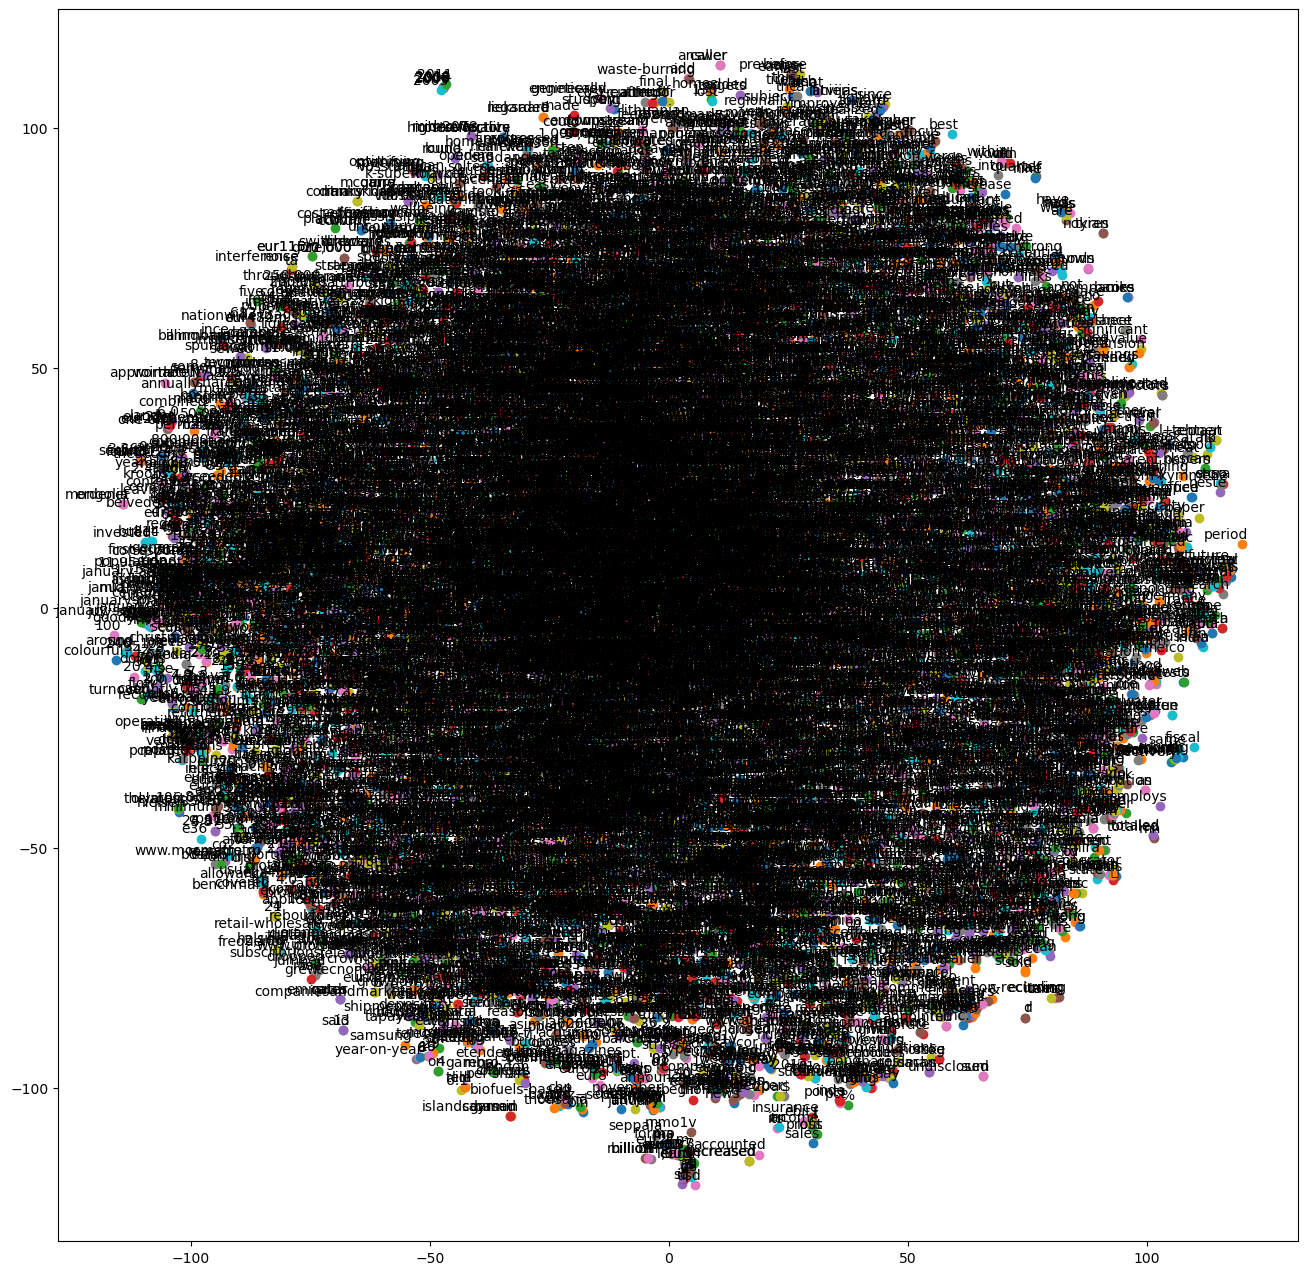

In [26]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.key_to_index:
        tokens.append(model.wv[word])
        labels.append(word)
    
    tokens = np.array(tokens)  # convert list to numpy array
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

tsne_plot(d2v_model)

# Create the LSTM Model


In [27]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding

# init layer
model = Sequential()

# emmbed word vectors
model.add(Embedding(len(d2v_model.wv.key_to_index)+1,20,input_length=X.shape[1],weights=[embedding_matrix],trainable=True))

# learn the correlations
def split_input(sequence):
     return sequence[:-1], tf.reshape(sequence[1:], (-1,1))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(3,activation="softmax"))

# output model skeleton
model.summary()
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 20)            233660    
                                                                 
 lstm (LSTM)                 (None, 50)                14200     
                                                                 
 dense (Dense)               (None, 3)                 153       
                                                                 
Total params: 248013 (968.80 KB)
Trainable params: 248013 (968.80 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
!pip install pydot pydotplus

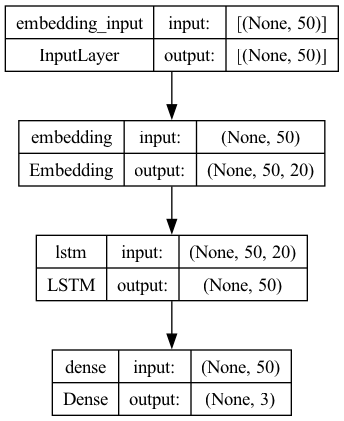

In [29]:
import pydot
import pydotplus
from keras.utils import plot_model
import os
os.environ["PATH"] += os.pathsep + '/opt/homebrew/Cellar/graphviz/9.0.0/lib/graphviz'
plot_model(model, to_file='model.png', show_shapes=True)

In [30]:
Y = pd.get_dummies(df['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.15, random_state = 42)
print('Train Set ->',X_train.shape,Y_train.shape)
print('Test Set ->',X_test.shape,Y_test.shape)

Train Set -> (4118, 50) (4118, 3)
Test Set -> (727, 50) (727, 3)


In [31]:
batch_size = 32
history=model.fit(X_train, Y_train, epochs =50, batch_size=batch_size, verbose = 2)

Epoch 1/50
129/129 - 2s - loss: 0.5536 - acc: 0.5935 - 2s/epoch - 14ms/step
Epoch 2/50
129/129 - 1s - loss: 0.4710 - acc: 0.6634 - 1s/epoch - 8ms/step
Epoch 3/50
129/129 - 1s - loss: 0.3495 - acc: 0.7613 - 1s/epoch - 8ms/step
Epoch 4/50
129/129 - 1s - loss: 0.2655 - acc: 0.8201 - 1s/epoch - 8ms/step
Epoch 5/50
129/129 - 1s - loss: 0.2268 - acc: 0.8453 - 1s/epoch - 8ms/step
Epoch 6/50
129/129 - 1s - loss: 0.1998 - acc: 0.8592 - 1s/epoch - 8ms/step
Epoch 7/50
129/129 - 1s - loss: 0.1819 - acc: 0.8728 - 1s/epoch - 8ms/step
Epoch 8/50
129/129 - 1s - loss: 0.1457 - acc: 0.9065 - 1s/epoch - 8ms/step
Epoch 9/50
129/129 - 1s - loss: 0.1019 - acc: 0.9473 - 1s/epoch - 9ms/step
Epoch 10/50
129/129 - 1s - loss: 0.0736 - acc: 0.9660 - 1s/epoch - 8ms/step
Epoch 11/50
129/129 - 1s - loss: 0.0457 - acc: 0.9801 - 1s/epoch - 8ms/step
Epoch 12/50
129/129 - 1s - loss: 0.0339 - acc: 0.9857 - 1s/epoch - 9ms/step
Epoch 13/50
129/129 - 1s - loss: 0.0288 - acc: 0.9881 - 1s/epoch - 9ms/step
Epoch 14/50
129/129 

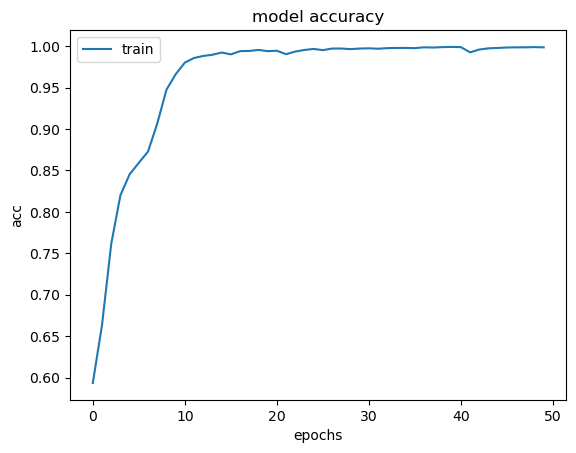

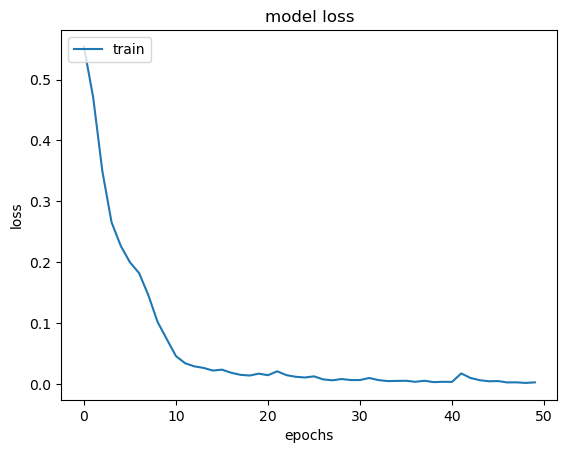

<Figure size 640x480 with 0 Axes>

In [32]:
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_accuracy.png')

# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_loss.png')

In [33]:
# evaluate the model
_, train_acc = model.evaluate(X_train, Y_train, verbose=2)
_, test_acc = model.evaluate(X_test, Y_test, verbose=2)
print('Train: %.3f, Test: %.4f' % (train_acc, test_acc))

129/129 - 0s - loss: 0.0040 - acc: 0.9985 - 479ms/epoch - 4ms/step
23/23 - 0s - loss: 1.1644 - acc: 0.7098 - 59ms/epoch - 3ms/step
Train: 0.999, Test: 0.7098


In [34]:
# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
print(yhat_probs)

# predict crisp classes for test set
yhat_classes = np.argmax(model.predict(X_test), axis=-1)
print(yhat_classes)

[[1.8838218e-04 9.9976546e-01 4.6147521e-05]
 [1.0000000e+00 1.3256590e-08 3.5436575e-08]
 [1.8050207e-04 9.9978811e-01 3.1482294e-05]
 ...
 [9.9881351e-01 1.1769914e-03 9.5416617e-06]
 [5.3270827e-07 9.9999952e-01 4.6211724e-08]
 [1.0000000e+00 3.2731993e-08 2.9754879e-08]]
23/23 [==============================] - 0s 2ms/step
[1 0 1 0 1 1 1 1 1 1 1 1 0 2 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 2 0 1 1 2 1 0 2
 0 0 1 0 1 2 1 0 1 1 1 0 1 2 1 0 2 1 0 1 1 0 1 0 0 0 0 1 1 1 1 0 0 1 1 0 1
 0 1 1 1 1 0 1 2 0 0 0 0 1 2 1 0 0 1 1 2 1 1 0 1 0 1 2 1 1 2 0 1 1 1 2 1 1
 1 2 0 1 0 1 0 0 0 0 0 0 1 1 1 0 1 0 1 0 0 2 1 0 1 0 2 1 0 1 1 1 1 1 0 0 1
 2 1 0 0 1 1 1 0 0 1 2 2 1 0 1 1 2 0 1 2 1 0 1 0 0 1 0 2 0 0 1 0 0 0 1 1 1
 2 1 2 1 1 1 0 0 1 2 0 1 1 1 0 1 1 1 1 1 0 1 1 0 1 2 1 1 1 1 1 1 2 0 0 0 1
 1 0 1 1 1 0 0 1 1 1 1 1 2 0 1 1 1 1 0 1 1 0 0 1 1 1 1 0 2 1 0 0 2 0 1 1 1
 1 0 0 1 0 2 2 2 1 1 1 1 1 2 0 1 1 1 0 0 0 1 0 1 1 1 1 1 1 0 1 0 2 0 1 2 1
 1 2 0 1 0 1 1 0 1 2 1 0 1 0 1 2 0 1 0 1 1 1 2 0 1 2 0 1 0 1 1 0 1 1 1 

In [35]:
rounded_labels=np.argmax(Y_test, axis=1)
rounded_labels

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 0, 1, 0, 0, 2, 2, 1,
       0, 0, 1, 0, 1, 0, 0, 2, 1, 1, 0, 2, 1, 0, 2, 0, 1, 1, 0, 1, 2, 1,
       0, 1, 1, 1, 0, 0, 2, 1, 0, 2, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 2, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 2, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 2, 2, 1, 0, 1, 1, 0, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 0, 2, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 2, 0,
       1, 1, 0, 1, 0, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 0, 0, 1, 0, 1, 0, 1, 2, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 2, 1, 2, 1, 2, 1, 1, 0, 0, 1, 0, 2, 1,
       2, 0, 1, 1, 0, 2, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1,
       0, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 0, 1, 2, 0, 1, 0, 1, 1, 1, 1,
       1, 2, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       2, 1, 2, 1, 1, 0, 1, 1, 2, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 2, 1, 0, 1, 0, 2, 2, 1, 1, 1, 0, 1, 0,

In [36]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(rounded_labels, yhat_classes)
cm

array([[143,  65,   7],
       [ 84, 316,  26],
       [ 10,  19,  57]])

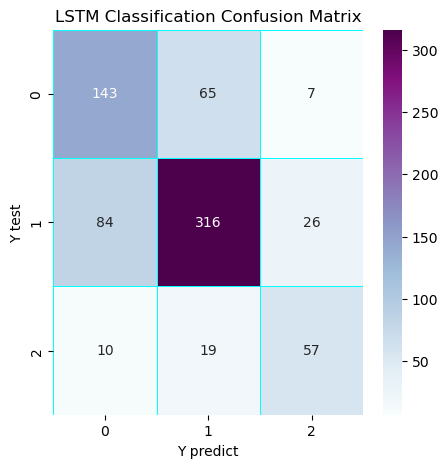

In [37]:
# The confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

lstm_val = confusion_matrix(rounded_labels, yhat_classes)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(lstm_val, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="BuPu")
plt.title('LSTM Classification Confusion Matrix')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()

# Validation

In [38]:
validation_size = 610

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 1, batch_size = batch_size)

print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

4/4 [==============================] - 0s 3ms/step - loss: 1.3330 - acc: 0.7009
score: 1.33
acc: 0.70


**Save Model**


In [39]:
model.save('best_model.keras')

In [40]:
from keras.models import load_model
model = load_model('best_model.keras')

def predict_class(message):
    sentiment_classes = ['Positive', 'Neutral', 'Negative']
    # Transforms text to a sequence of integers using a tokenizer object
    seq = tokenizer.texts_to_sequences(message)
    # Pad sequences to the same length
    padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)
    # Do the prediction using the loaded model
    pred = model.predict(padded)
    labels = ['0','1','2']
    # Print the predicted sentiment
    print(pred, labels[np.argmax(pred)])
    print('The predicted sentiment is', sentiment_classes[np.argmax(pred)])

**Test with new and different data set aside from the data to build the model.**

note : sentiment  = {'positive': 0,'neutral': 1,'negative':2} 

In [41]:
predict_class(['Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007 representing 7.7 % of net sales'])
predict_class(['Bids or offers include at least 1,000 shares and the value of the shares must correspond to at least EUR 4,000.'])
predict_class(['Raute reported a loss per share of EUR 0.86 for the first half of 2009 , against EPS of EUR 0.74 in the corresponding period of 2008.'])
predict_class(['such massive asteroid hit will certainly create new business opportunities'])
predict_class(['Congratulations! you have won a $1,000 Walmart gift card'])
predict_class(['so does anyone else not open Snapchat anymore ? or is it just me ... ugh this so sad.'])
predict_class(['@elonmusk had a terrible experience with a very pushy sales guy from tesla Stanford shop while shopping for model x'])
predict_class(['The local electronics industry is expected to remain stable amid layoff concerns surrounding Japanese electronics giants operating in the country, an official says.'])
predict_class(['The local electronics industry is amid layoff concerns and last year has laid off tens of employees'])

1/1 [==============================] - 0s 170ms/step
[[1.0000000e+00 5.4678533e-09 1.3482621e-08]] 0
The predicted sentiment is Positive
1/1 [==============================] - 0s 11ms/step
[[8.534934e-10 1.000000e+00 6.500433e-10]] 1
The predicted sentiment is Neutral
1/1 [==============================] - 0s 10ms/step
[[0.01206104 0.002381   0.985558  ]] 2
The predicted sentiment is Negative
1/1 [==============================] - 0s 9ms/step
[[9.9811965e-01 1.0186835e-04 1.7784269e-03]] 0
The predicted sentiment is Positive
1/1 [==============================] - 0s 10ms/step
[[9.9998593e-01 2.9636569e-06 1.1121035e-05]] 0
The predicted sentiment is Positive
1/1 [==============================] - 0s 10ms/step
[[3.5103945e-10 1.0000000e+00 5.0142906e-10]] 1
The predicted sentiment is Neutral
1/1 [==============================] - 0s 9ms/step
[[9.9995220e-01 4.7334997e-05 4.8880298e-07]] 0
The predicted sentiment is Positive
1/1 [==============================] - 0s 9ms/step
[[3.2184816e

## FinancialBERT for Sentiment Analysis


FinancialBERT is a BERT model pre-trained on a large corpora of financial texts. The purpose is to enhance financial NLP research and practice in financial domain, hoping that financial practitioners and researchers can benefit from this model without the necessity of the significant computational resources required to train the model.

The model was fine-tuned for Sentiment Analysis task on Financial PhraseBank dataset. Experiments show that this model outperforms the general BERT and other financial domain-specific models.

More details on FinancialBERT's pre-training process can be found at: https://www.researchgate.net/publication/358284785_FinancialBERT_-_A_Pretrained_Language_Model_for_Financial_Text_Mining

![FinBERT.png](FinBERT.png)

In [42]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline

model = BertForSequenceClassification.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis",num_labels=3)
tokenizer = BertTokenizer.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis")

nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

sentences = ["Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007 representing 7.7 % of net sales.",  
             "Bids or offers include at least 1,000 shares and the value of the shares must correspond to at least EUR 4,000.", 
             "Raute reported a loss per share of EUR 0.86 for the first half of 2009 , against EPS of EUR 0.74 in the corresponding period of 2008.", 
             ]
results = nlp(sentences)
print(results)

[{'label': 'positive', 'score': 0.9998133778572083}, {'label': 'neutral', 'score': 0.9997822642326355}, {'label': 'negative', 'score': 0.9877365231513977}]
